In [ ]:
# pip install tensorflow==2.17.0

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import image_dataset_from_directory as IMFD
import matplotlib.pyplot as plt

print(tf.__version__) # Should be Tensorflow version 2.17.X

2.17.1


In [26]:
SOURCE = '/content/drive/MyDrive/TasteTrip/Production/v2'

# Main dataset
DATASET_PATH = os.path.join(SOURCE, "raw_dataset")

# Split dataset
SPLIT_DATASET_PATH = os.path.join(SOURCE, "split_dataset")

TRAIN_PATH = os.path.join(SPLIT_DATASET_PATH, 'train')
VAL_PATH = os.path.join(SPLIT_DATASET_PATH, 'val')
TEST_PATH = os.path.join(SPLIT_DATASET_PATH, 'test')

# Food Categories
FOOD_LIST = sorted(os.listdir(TRAIN_PATH)) # Remember to always SORT
NUM_OF_FOOD = len(FOOD_LIST)

print('Food total:', NUM_OF_FOOD)

print('\nFood category:', FOOD_LIST)

Food total: 10

Food category: ['bakso', 'batagor', 'bubur', 'gado-gado', 'mie ayam', 'nasi goreng', 'nasi padang', 'rawon', 'sate ayam', 'soto ayam']


## Generate Tensorflow Dataset

Using image_dataset_from_directory from keras.utils for easy data pipeline

In [4]:
LABEL_MODE = 'categorical'
COLOR_MODE = 'rgb'
BATCH_SIZE = 32
IMAGE_SIZE = (384, 384)
SEED = 314

SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

In [5]:
# Create train dataset
train_dataset = IMFD(
    TRAIN_PATH,
    label_mode=LABEL_MODE,
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=SEED,
)

# Create validation dataset
val_dataset = IMFD(
    VAL_PATH,
    label_mode=LABEL_MODE,
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=SEED,
)

test_dataset = IMFD(
    TEST_PATH,
    label_mode=LABEL_MODE,
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=SEED,
)

Found 1098 files belonging to 10 classes.
Found 133 files belonging to 10 classes.
Found 146 files belonging to 10 classes.


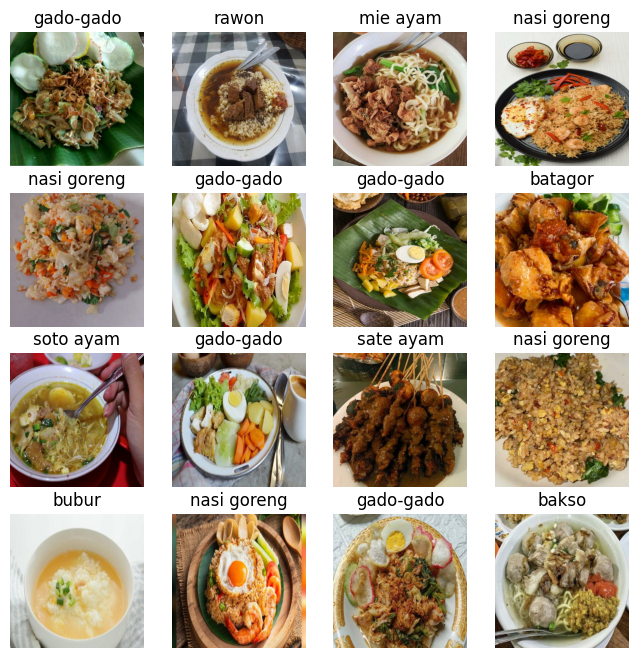

In [27]:
def plot_dataset_batch_images(data_generator, class_names):
    plt.figure(figsize=(8, 8))

    for images, labels in data_generator.take(1):
        for i in range(16):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))

            # Get the class index using one-hot encoding
            class_index = np.argmax(labels[i])

            # Display class name as title
            plt.title(class_names[class_index])
            plt.axis("off")

plot_dataset_batch_images(train_dataset, FOOD_LIST)

In [10]:
train_ds = (train_dataset.cache().shuffle(SHUFFLE_BUFFER_SIZE).prefetch(PREFETCH_BUFFER_SIZE))

val_ds = (val_dataset.cache().prefetch(PREFETCH_BUFFER_SIZE))
test_ds = (test_dataset.cache().prefetch(PREFETCH_BUFFER_SIZE))

## Preprocessing Data

In [11]:
rescale_layer = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255)
])

augmentation_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(
        (-0.2, 0.2),
        fill_mode='reflect',
        interpolation='bilinear'
    ),
    tf.keras.layers.RandomTranslation(
        (-0.15, 0.15),
        (-0.15, 0.15),
        fill_mode='reflect',
        interpolation='bilinear'
    ),
])

In [12]:
# Rescale
train_ds = train_dataset.map(lambda x, y: (rescale_layer(x), y))
val_ds = val_dataset.map(lambda x, y: (rescale_layer(x), y))
test_ds = test_dataset.map(lambda x, y: (rescale_layer(x), y))

# Augment only train set
train_ds = train_ds.map(lambda x, y: (augmentation_layer(x), y))

## Building The Model

In [ ]:
input_shape = (384, 384, 3)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
    include_preprocessing=False
)

base_model.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=input_shape)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(NUM_OF_FOOD, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 384, 384, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-s (Functional)        │ (None, 12, 12, 1280)        │      20,331,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,121,130 (80.57 MB)

 Trainable params: 789,770 (3.01 MB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [ ]:
learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

## Callbacks

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def __init__(self, checkpoint_filepath):
        super(myCallback, self).__init__()
        self.checkpoint_filepath = checkpoint_filepath

    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.94 and logs.get('val_accuracy') > 0.92):
            print("\nReached desired accuracy, stopping training!")
            self.model.stop_training = True

        self.model.save(self.checkpoint_filepath)

In [ ]:
checkpoint_filepath = os.path.join(SOURCE, 'v2_efficientnetv2s_model.keras')

callbacks = [
    myCallback(checkpoint_filepath),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=False,
                                        monitor='val_accuracy',
                                        mode='max',
                                        save_best_only=True)
]

## Train the model

In [ ]:
EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9427 - loss: 0.1942 - val_accuracy: 0.8571 - val_loss: 0.4895
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9401 - loss: 0.1820 - val_accuracy: 0.8421 - val_loss: 0.4938
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9451 - loss: 0.1716 - val_accuracy: 0.8496 - val_loss: 0.4840
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9452 - loss: 0.1901 - val_accuracy: 0.8647 - val_loss: 0.4895
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9452 - loss: 0.1593 - val_accuracy: 0.8421 - val_loss: 0.5138
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9443 - loss: 0.1714 - val_accuracy: 0.8647 - val_loss: 0.4912
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9486 - loss: 0.1598 - val_accuracy: 0.8571 - val_loss: 0.4859
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9550 - loss: 0.1609 - val_accuracy: 0.8571 - val_loss:

In [ ]:
model.evaluate(test_ds)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.8660 - loss: 0.3664


[0.3794826865196228, 0.8767123222351074]

In [ ]:
# model.save(os.path.join(SOURCE, 'models', 'v2_efficientnetv2s_model.keras'))

## After train model test

After train model or when you have the model and want to test it

In [8]:
model = tf.keras.models.load_model('/content/drive/MyDrive/TasteTrip/Production/v2/models/v2_efficientnetv2s_model.keras') # If you already have the model

In [13]:
model.evaluate(test_ds)

5/5 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - accuracy: 0.8669 - loss: 0.3764


[0.3794824481010437, 0.8767123222351074]

In [14]:
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Get true labels from the test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)

5/5 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step


In [21]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Predictions (convert probabilities to class labels if needed)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels (convert one-hot encoded labels to class labels if needed)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
if len(y_true.shape) > 1:  # If one-hot encoded
    y_true = np.argmax(y_true, axis=1)

# Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Classification Report:")
print(classification_report(y_true, y_pred))


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step
Accuracy: 0.11
Precision: 0.10
Recall: 0.11
F1-Score: 0.11
Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.20      0.18        15
           1       0.00      0.00      0.00        15
           2       0.09      0.07      0.08        15
           3       0.11      0.14      0.12        14
           4       0.06      0.07      0.06        15
           5       0.13      0.12      0.13        16
           6       0.08      0.07      0.08        14
           7       0.14      0.14      0.14        14
           8       0.13      0.13      0.13        15
           9       0.12      0.15      0.14        13

    accuracy                           0.11       146
   macro avg       0.10      0.11      0.11       146
weighted avg       0.10      0.11      0.11       146

